#Semantic Segmentation of Aerial Images
###Road Training

####Mounting Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/MapSegClean/"
%cd gdrive/My\ Drive/MapSegClean/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/MapSegClean


####Importing Libraries

In [0]:
!nvidia-smi

Thu Mar 12 05:50:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import cv2
import numpy as np
import h5py

In [0]:
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [0]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

from skimage import color
import pickle

####Read Data From h5 files

In [0]:
h5f = h5py.File('Cpy_clean_roadlabel.h5','r')
roadlabel = h5f['clean_roadlabel'][:]
h5f.close()

h5f = h5py.File('Cpy_clean_road.h5','r')
road = h5f['clean_road'][:]
h5f.close()

In [0]:
#for i in range(road.shape[0]):
#  cv2.imwrite("Road/" + str(i) + ".png", road[i])

#for i in range(roadlabel.shape[0]):
#  cv2.imwrite("RoadLabel/" + str(i) + ".png", roadlabel[i])
pip install -U segmentation-models

####Loss Function

In [0]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


####Preprocecssing Data

In [0]:
print(roadlabel.shape)

roadlabelgray = []

for i in range(roadlabel.shape[0]):
  roadlabelgray.append(cv2.cvtColor(roadlabel[i], cv2.COLOR_BGR2GRAY))

roadlabelgray = np.asarray(roadlabelgray)

roadlabel = np.expand_dims(roadlabelgray, -1)

del roadlabelgray

print(roadlabel.shape)

(22911, 256, 256, 3)
(22911, 256, 256, 1)


In [0]:
seed = 56
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3

####Model

In [0]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [0]:
model = Unet('efficientnetb7', input_shape=(256, 256, 3), encoder_weights=None, decoder_use_batchnorm=True)
#model = Unet(input_shape=(256, 256, 3), weights=None, activation='elu')
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 64) 0         

####Hyperparameters


In [0]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32

####Path to save Model

In [0]:
model_path = "Models/Final_unet_efficientnetb7_road_weights.h5"

In [0]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          road:  4.2 GiB
                         Model:  2.0 KiB
                        Conv2D:  2.0 KiB
            BatchNormalization:  2.0 KiB
                       Dropout:  1.0 KiB
                        Lambda:  1.0 KiB
               Conv2DTranspose:  1.0 KiB
                  MaxPooling2D:  1.0 KiB
                       MeanIoU:  1.0 KiB
                          _i10:  615.0 B


####Callbacks

In [0]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://e4506fb0.ngrok.io


In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from datetime import datetime

checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [0]:
earlystopper = EarlyStopping(monitor = 'val_loss', 
                             min_delta = 0, 
                             patience = 7,
                             mode='auto',
                            restore_best_weights = True)

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


####Compile Model

In [0]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])   

In [0]:
history = model.fit(road,
                    (roadlabel.astype(np.uint8)/255).astype(np.uint8),
                    validation_split = 0.1,
                    epochs=5,
                    batch_size = 4,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )

with open("History/Unet_ efficientnetb7_Road_History.pickle", 'wb') as f:
    pickle.dump(history, f)



Train on 20619 samples, validate on 2292 samples


Epoch 1/5
20619/20619 [==============================] - 2317s 112ms/step - loss: 0.4829 - iou_coef: 0.2935 - val_loss: 0.3483 - val_iou_coef: 0.4226

Epoch 00001: val_loss improved from inf to 0.34825, saving model to Models/Final_unet_efficientnetb7_road_weights.h5

Epoch 2/5
20619/20619 [==============================] - 2229s 108ms/step - loss: 0.3390 - iou_coef: 0.4513 - val_loss: 0.3234 - val_iou_coef: 0.5284

Epoch 00002: val_loss improved from 0.34825 to 0.32339, saving model to Models/Final_unet_efficientnetb7_road_weights.h5
Epoch 3/5
11468/20619 [===============>..............] - ETA: 16:09 - loss: 0.3178 - iou_coef: 0.5061

In [0]:
model.load_weights(model_path)

history = model.fit(road,
                    (roadlabel.astype(np.uint8)/255).astype(np.uint8),
                    validation_split = 0.1,
                    epochs=5,
                    batch_size = 4,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )



Train on 20619 samples, validate on 2292 samples


Epoch 1/5
20619/20619 [==============================] - 2266s 110ms/step - loss: 0.3166 - iou_coef: 0.5109 - val_loss: 0.3028 - val_iou_coef: 0.5327

Epoch 00001: val_loss improved from inf to 0.30282, saving model to Models/Final_unet_efficientnetb7_road_weights.h5

Epoch 2/5
20619/20619 [==============================] - 2154s 104ms/step - loss: 0.3041 - iou_coef: 0.5403 - val_loss: 0.2933 - val_iou_coef: 0.5646

Epoch 00002: val_loss improved from 0.30282 to 0.29332, saving model to Models/Final_unet_efficientnetb7_road_weights.h5
Epoch 3/5
20619/20619 [==============================] - 2152s 104ms/step - loss: 0.2929 - iou_coef: 0.5590 - val_loss: 0.2810 - val_iou_coef: 0.5764

Epoch 00003: val_loss improved from 0.29332 to 0.28101, saving model to Models/Final_unet_efficientnetb7_road_weights.h5
Epoch 4/5
20619/20619 [==============================] - 2150s 104ms/step - loss: 0.2850 - iou_coef: 0.5723 - val_loss: 0.2801 - val_i

In [0]:
#import pickle
#with open("History/Road_History.pickle", 'rb') as f:
#    history = pickle.load(f)

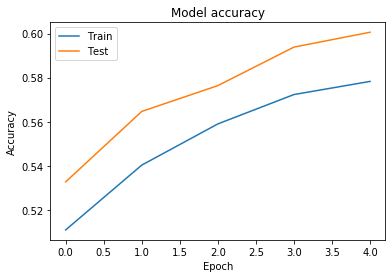

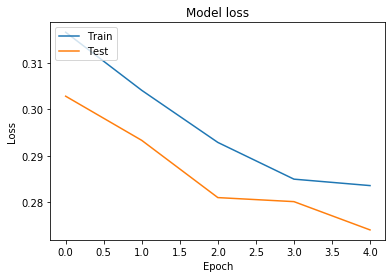

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.load_weights(model_path)

history = model.fit(road,
                    (roadlabel.astype(np.uint8)/255).astype(np.uint8),
                    validation_split = 0.1,
                    epochs=5,
                    batch_size = 4,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )

Train on 20619 samples, validate on 2292 samples
Epoch 1/5
20619/20619 [==============================] - 5305s 257ms/step - loss: 0.2773 - iou_coef: 0.5871 - val_loss: 0.2695 - val_iou_coef: 0.6070

Epoch 00001: val_loss improved from inf to 0.26947, saving model to Models/Final_unet_efficientnetb7_road_weights.h5

Epoch 2/5
 4292/20619 [=====>........................] - ETA: 1:07:48 - loss: 0.2741 - iou_coef: 0.5938

KeyboardInterrupt: ignored

In [0]:
model.load_weights(model_path)

history = model.fit(road,
                    (roadlabel.astype(np.uint8)/255).astype(np.uint8),
                    validation_split = 0.1,
                    epochs=5,
                    batch_size = 4,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )



Train on 20619 samples, validate on 2292 samples


Epoch 1/5
20619/20619 [==============================] - 2375s 115ms/step - loss: 0.2736 - iou_coef: 0.5934 - val_loss: 0.2829 - val_iou_coef: 0.5648

Epoch 00001: val_loss improved from inf to 0.28287, saving model to Models/Final_unet_efficientnetb7_road_weights.h5

Epoch 2/5
20619/20619 [==============================] - 2285s 111ms/step - loss: 0.2723 - iou_coef: 0.5971 - val_loss: 0.2692 - val_iou_coef: 0.6213

Epoch 00002: val_loss improved from 0.28287 to 0.26917, saving model to Models/Final_unet_efficientnetb7_road_weights.h5
Epoch 3/5
20619/20619 [==============================] - 2288s 111ms/step - loss: 0.2677 - iou_coef: 0.6054 - val_loss: 0.2775 - val_iou_coef: 0.6001

Epoch 00003: val_loss did not improve from 0.26917
Epoch 4/5
20619/20619 [==============================] - 2283s 111ms/step - loss: 0.2646 - iou_coef: 0.6066 - val_loss: 0.2618 - val_iou_coef: 0.6195

Epoch 00004: val_loss improved from 0.26917 to 0.2617

In [0]:
opt = keras.optimizers.adam(0.00001)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])   

In [0]:
model.load_weights(model_path)

history = model.fit(road,
                    (roadlabel.astype(np.uint8)/255).astype(np.uint8),
                    validation_split = 0.1,
                    epochs=5,
                    batch_size = 4,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )



Train on 20619 samples, validate on 2292 samples


Epoch 1/5
20619/20619 [==============================] - 5322s 258ms/step - loss: 0.2546 - iou_coef: 0.6259 - val_loss: 0.2562 - val_iou_coef: 0.6262

Epoch 00001: val_loss improved from inf to 0.25615, saving model to Models/Final_unet_efficientnetb7_road_weights.h5

Epoch 2/5
20619/20619 [==============================] - 5244s 254ms/step - loss: 0.2522 - iou_coef: 0.6271 - val_loss: 0.2555 - val_iou_coef: 0.6274

Epoch 00002: val_loss improved from 0.25615 to 0.25553, saving model to Models/Final_unet_efficientnetb7_road_weights.h5
Epoch 3/5
20619/20619 [==============================] - 5227s 254ms/step - loss: 0.2501 - iou_coef: 0.6292 - val_loss: 0.2563 - val_iou_coef: 0.6275

Epoch 00003: val_loss did not improve from 0.25553
Epoch 4/5
 4608/20619 [=====>........................] - ETA: 1:06:00 - loss: 0.2483 - iou_coef: 0.6370

In [0]:
opt = keras.optimizers.adam(0.00001)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])   

In [0]:
model.load_weights(model_path)

history = model.fit(road,
                    (roadlabel.astype(np.uint8)/255).astype(np.uint8),
                    validation_split = 0.1,
                    epochs=5,
                    batch_size = 4,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )



Train on 20619 samples, validate on 2292 samples


Epoch 1/5
20619/20619 [==============================] - 5257s 255ms/step - loss: 0.2516 - iou_coef: 0.6292 - val_loss: 0.2558 - val_iou_coef: 0.6275

Epoch 00001: val_loss improved from inf to 0.25583, saving model to Models/Final_unet_efficientnetb7_road_weights.h5

Epoch 2/5
20619/20619 [==============================] - 5164s 250ms/step - loss: 0.2494 - iou_coef: 0.6341 - val_loss: 0.2565 - val_iou_coef: 0.6266

Epoch 00002: val_loss did not improve from 0.25583
Epoch 3/5
18624/20619 [==========================>...] - ETA: 8:07 - loss: 0.2481 - iou_coef: 0.6319

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()